#### Load values

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import datetime, timedelta

In [12]:
Values = pd.read_csv("./data/Values.csv", delimiter=',')
Errors = pd.read_csv("./data/Errors.csv", delimiter=',')
All2020 = Values[36240:]
E2020 = Errors[36240:]
# Load model
predictions = pd.read_csv("./data/Climatology.csv", delimiter=',')
P2020 = predictions[36240:]
coefs2020 = pd.read_csv("./data/Coefficients.csv", delimiter=',')
sg_coefs2020 = pd.read_csv("./data/CoefficientsSigma.csv", delimiter=',')

#### Use SAMOS correction

$fg_{corr} = (b_0 + b_1 \tilde{m}) \cdot \sigma_{obs} + \mu_{obs}$

$\sigma_{corr} = \exp[c_0 + c_1 log(\tilde{s})] \cdot \sigma_{obs}$

In [13]:
def model(station, All=All2020, E=E2020, P=P2020, coefs=coefs2020, sg_coefs=sg_coefs2020):
    FG_mean = All["b'"+station+"_fg"].values
    Obs = All["b'"+station+"_obs"].values
    FG_std = E["b'"+station+"_fg"].values
    E_O = E["b'"+station+"_obs"].values
    FG_mu = P["b."+station+"_fg _mu"].values
    Obs_mu = P["b."+station+"_obs _mu"].values
    FG_sg = P["b."+station+"_fg _sg"].values
    Obs_sg = P["b."+station+"_obs _sg"].values
    SD_mu = P["b."+station+"_fg _mu_sd"].values
    SD_sg = P["b."+station+"_fg _sg_sd"].values

    for i in range(4):
        if coefs['x'][i] == "b."+station+"_fg":
            b0 = float(coefs['x'][i+1])
            b1 = float(coefs['x'][i+2])
    
    for i in range(4):
        if sg_coefs['x'][i] == "b."+station+"_fg":
            c0 = float(sg_coefs['x'][i+1])
            c1 = float(sg_coefs['x'][i+2])
            
    m_tilde = (FG_mean - FG_mu)/FG_sg
    FG_corr = (b0 + b1*m_tilde) * Obs_sg + Obs_mu
    o_tilde = (Obs - Obs_mu)/Obs_sg
    log_s_tilde = (np.log(FG_std) - SD_mu)/SD_sg #test with more logs
    SD_corr = Obs_sg * np.exp(c0 + c1*log_s_tilde)
    log_o_tilde = np.log(E_O/Obs_sg)
    
    return Obs, FG_mean, FG_corr, E_O, FG_std, SD_corr

In [14]:
Obs, FG_mean, FG_corr, E_O, FG_std, SD_corr = model("11126")

#### Plot the data

In [15]:
def obs_fg_plot(station, name, year, index, length):
    Obs, FG_mean, FG_corr, E_O, FG_std, SD_corr = model(station)
    if year == 2020: 
        t = np.arange(datetime(year,1,1,0,0), datetime(year,11,1,0,0), timedelta(hours=1)).astype(datetime)
    else:
        t = np.arange(datetime(year,1,1,0,0), datetime(year+1,1,1,0,0), timedelta(hours=1)).astype(datetime)

    plt.figure(figsize=(16,6))
    plt.title(name, fontsize=15)
    plt.plot(t[index:index+length], Obs[index:index+length], color='black', label= 'Observations')
    plt.plot(t[index:index+length], FG_corr[index:index+length], color='blue', label = 'Corrected FG')
    plt.fill_between(t[index:index+length], FG_corr[index:index+length], FG_corr[index:index+length]+SD_corr[index:index+length], color='#539ecd', alpha = 0.5, label=r"Corrected FG $\pm$ Std")
    plt.fill_between(t[index:index+length], FG_corr[index:index+length], FG_corr[index:index+length]-SD_corr[index:index+length], color='#539ecd', alpha = 0.5)
    plt.plot(t[index:index+length], FG_mean[index:index+length], color='red', label = 'FG')
    plt.fill_between(t[index:index+length], FG_mean[index:index+length], FG_mean[index:index+length]+FG_std[index:index+length], color='salmon', alpha = 0.5, label=r"FG $\pm$ Std")
    plt.fill_between(t[index:index+length], FG_mean[index:index+length], FG_mean[index:index+length]-FG_std[index:index+length], color='salmon', alpha = 0.5)
    plt.xlabel('Days', fontsize=15)
    plt.ylabel('Temperature [K]', fontsize=15)
    plt.legend()
    plt.grid()

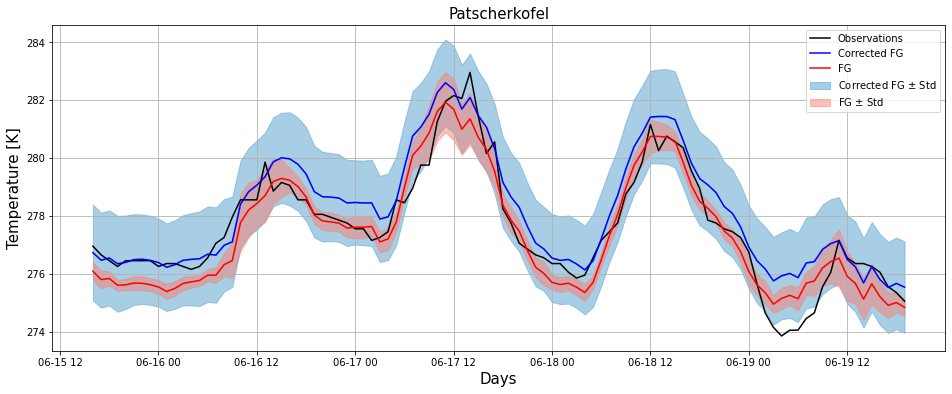

In [16]:
obs_fg_plot(station="11126", name="Patscherkofel", year= 2020, index=4000, length=100)

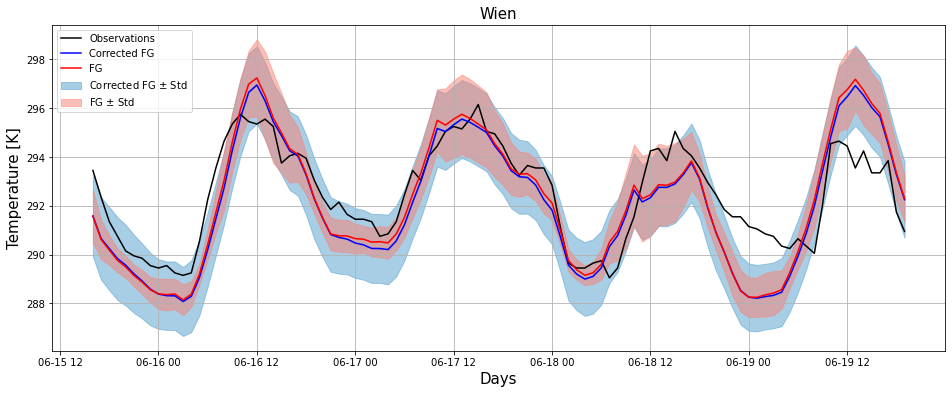

In [17]:
obs_fg_plot(station="11035", name="Wien", year= 2020, index=4000, length=100)

#### Calculate BIAS before and after the SAMOS correction

In [18]:
def BIAS(station):
    Obs, FG_mean, FG_corr, E_O, FG_std, SD_corr = model(station)
    bias_1 = np.nanmean(Obs-FG_mean)
    bias_2 = np.nanmean(Obs-FG_corr)
    return bias_1, bias_2

In [19]:
BIAS("11126")

(0.5924600308651656, -0.22636473776370605)

In [20]:
BIAS("11035")

(0.28203865461021466, -0.02190697149533248)